In [1]:
import pandas as pd
import requests
import os
import json
import tqdm
import time
import random
import numpy as np
from pdfminer.pdfparser import PDFParser, PDFSyntaxError
from pdfminer.pdfdocument import (
    PDFDocument,
    PDFNoValidXRef,
    PSEOF,
    PDFPasswordIncorrect,
)
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import resolve1
import matplotlib.pyplot as plt

In [2]:
# setting output directory

output_path = "/data/dssg/occrp/data/aleph-exploration/output"
if not os.path.exists(output_path):
    os.makedirs(output_path)

collections_files_path = os.path.join(output_path, "collections")

## Download of collection and documents data

In [58]:
collections_response = requests.get("https://aleph.occrp.org/api/2/collections?limit=10000").json()

with open(os.path.join(output_path, "collections.json"), "w") as collections_file:
    json.dump(
        collections_response,
        collections_file,
        indent=4,
        sort_keys=True,
        ensure_ascii=False,
    )

In [ ]:
collection_ids = [collection["id"] for collection in collections_response["results"]]


if not os.path.exists(collections_files_path):
    os.makedirs(collections_files_path)

for collection_id in tqdm.tqdm(collection_ids):
    documents_response = requests.get(
        "https://aleph.occrp.org/api/2/entities?" f"filter:schema=Document&filter:collection_id={collection_id}&limit=10000"
    ).json()

    with open(os.path.join(collections_files_path, f"{collection_id}.json"), "w") as collections_docs:
        json.dump(
            documents_response,
            collections_docs,
            indent=4,
            sort_keys=True,
            ensure_ascii=False,
        )

    time.sleep(2)

# missing: index 77

## Loading data

In [3]:
# loading collections documents data
collections_documents_data = []
for collection_filename in os.listdir(collections_files_path):
    with open(os.path.join(collections_files_path, collection_filename)) as collection_file:
        collections_documents_data.append(
            {
                "collection_id": collection_filename[:-5],
                "documents_collected": json.load(collection_file)["total"],
            }
        )

collections_documents_df = pd.DataFrame(collections_documents_data)

In [4]:
# loading collections
with open(os.path.join(output_path, "collections.json")) as collections_file:
    collections_data = json.load(collections_file)

collections_df = pd.DataFrame(collections_data["results"])

# merging
collections_df = collections_df.merge(collections_documents_df, how="left", on="collection_id")

In [5]:
print(f"Aleph contains {len(collections_df)} collections with {collections_df['count'].sum()} entities in total.")

print(f"{len(collections_documents_df)} of those collections are explored in this notebook.")

print(f"Only {len(collections_df[collections_df['documents_collected']>0])} collections had retrivable documents.")

print(
    f"{int(collections_df['documents_collected'].sum())} documents of those collections were retrieved. "
    "Aleph API has a limitation of 10,000 documents per collection."
)

Aleph contains 252 collections with 353541226 entities in total.
250 of those collections are explored in this notebook.
Only 71 collections had retrivable documents.
101671 documents of those collections were retrieved. Aleph API has a limitation of 10,000 documents per collection.


## Random sample of Aleph documents

In [6]:
collections_ids_non_empty = collections_df[collections_df["documents_collected"] > 0]["collection_id"]

In [7]:
documents = []

for collection_id in collections_ids_non_empty:
    with open(os.path.join(collections_files_path, f"{collection_id}.json")) as collection_file:
        documents.extend(json.load(collection_file)["results"])

In [8]:
documents_df = pd.DataFrame(documents)
documents_df["api_url"] = documents_df["links"].apply(lambda d: d["self"])
documents_df["mimeType"] = documents_df["properties"].apply(lambda d: d["mimeType"][0] if "mimeType" in d else np.NaN)
documents_df["fileName"] = documents_df["properties"].apply(lambda d: d["fileName"][0] if "fileName" in d else np.NaN)
documents_df["sourceUrl"] = documents_df["properties"].apply(lambda d: d["sourceUrl"][0] if "sourceUrl" in d else np.NaN)
documents_df["fileName"] = documents_df["properties"].apply(lambda d: d["fileName"][0] if "fileName" in d else np.NaN)
documents_df["collection_id"] = documents_df["collection"].apply(lambda d: d["collection_id"])

In [12]:
documents_df["mimeType"].value_counts()

inode/x-empty                                                              40311
application/pdf                                                            29641
text/html                                                                  12592
image/jp2                                                                   2407
application/vnd.ms-fontobject                                               1884
text/plain                                                                  1368
application/x-bittorrent                                                    1077
text/xml                                                                    1009
application/zip                                                              753
image/gif                                                                    674
application/gzip                                                             652
image/jpeg                                                                   555
image/vnd.djvu              

In [9]:
def is_pdf(row):
    return (
        (row["mimeType"] == "application/pdf")
        or (str(row["fileName"])[-3:] == "pdf")
        or (str(row["sourceUrl"])[-3:] == "pdf")
    )


documents_df["is_pdf"] = documents_df.apply(is_pdf, axis=1)

In [10]:
documents_df["is_pdf"].value_counts()

True     52861
False    48804
Name: is_pdf, dtype: int64

In [11]:
pdf_documents_df = documents_df[documents_df["is_pdf"]]

documents_sample_df = pdf_documents_df.sample(frac=1, random_state=100).groupby("collection_id").head(2)

print(f"{len(documents_sample_df)} documents were random sampled")

106 documents were random sampled


### Download of random sample PDF

In [89]:
documents_sample_path = os.path.join(output_path, "documents_sample")
if not os.path.exists(documents_sample_path):
    os.makedirs(documents_sample_path)

for i, row in tqdm.tqdm(documents_sample_df.iterrows()):

    document_response = requests.get(row["api_url"]).json()
    with open(os.path.join(documents_sample_path, f"{row['id']}.pdf"), "wb") as document_file:
        pdf_response = requests.get(document_response["links"]["file"])
        document_file.write(pdf_response.content)

106it [05:23,  3.05s/it]


In [91]:
def pdf_number_of_pages(pdf_path):
    with open(pdf_path, "rb") as pdf_file:
        try:
            parser = PDFParser(pdf_file)
            document = PDFDocument(parser)
            return resolve1(document.catalog["Pages"])["Count"]
        except Exception as e:
            # (PDFSyntaxError, PDFNoValidXRef, PSEOF, KeyError, PDFPasswordIncorrect)
            return np.NaN


documents_sample_df["number_of_pages"] = documents_sample_df["id"].apply(
    lambda document_id: pdf_number_of_pages(os.path.join(documents_sample_path, f"{document_id}.pdf"))
)

Data-loss while decompressing corrupted data


In [93]:
documents_sample_df["number_of_pages"].isnull().value_counts(dropna=False)

True     66
False    40
Name: number_of_pages, dtype: int64

<AxesSubplot:>

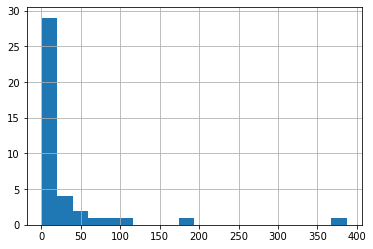

In [95]:
documents_sample_df["number_of_pages"].hist(bins=20)

In [96]:
documents_sample_df["number_of_pages"].describe()

count     40.000000
mean      30.650000
std       67.300531
min        1.000000
25%        2.000000
50%        8.500000
75%       22.500000
max      387.000000
Name: number_of_pages, dtype: float64

In [100]:
documents_sample_df[documents_sample_df["fileName"].isnull()]["number_of_pages"].value_counts(dropna=False)

NaN      38
2.0       4
1.0       2
10.0      1
177.0     1
8.0       1
3.0       1
22.0      1
65.0      1
56.0      1
Name: number_of_pages, dtype: int64